In [1]:
# Run this cell in a folder contained by the current project
using Pkg
#Pkg.activate()                  # Walks up the path tree until finds Project.toml
#Pkg.activate(".")              # 
#Pkg.activate("@__DIR__")       # 
Pkg.activate("../../../")      #
Pkg.instantiate()

  Activating project at `~/Workbench/2025/research/ranking-futbol`


In [2]:
using Plots
using LaTeXStrings
using Graphs
#using MetaGraphs
#using MetaGraphsNext
using GraphPlot
using SimpleWeightedGraphs
using Karnak
using NetworkLayout
using Colors
using Random
using LinearAlgebra
using OffsetArrays
using SparseArrays
using Serialization
using IterativeSolvers
using Krylov
using BenchmarkTools
using Profile
using ProfileView
using Statistics
using DifferentialEquations
using LoopVectorization
using Folds
using Transducers
using Distributed
using JLD2
using OnlineStats
using ImageFiltering
using SavitzkyGolay
using Interpolations
using DataInterpolations
using Polynomials
using CurveFit
using DataFrames
using LsqFit
using ForwardDiff
using DelimitedFiles
using JSON
using Dates

# Utils

## Enumerator

Tools to compute a running enumeration of a "list" of objects.

In [3]:
function enum!(d,k)
    return get!(d,k,length(d)+1)
end

enum! (generic function with 1 method)

### Test

## Running Statistics

Tools to compute running statistics such as mean and std from a stream of numbers.

In [4]:
mutable struct RunningStat
    n::Int
    m::Real # mean
    s::Real # std
end

function RunningStat()
    return RunningStat(0,0.0,0.0)
end

function Base.push!(rs::RunningStat,v::Real)
    if rs.n>0
        rs.n += 1
        new_m = rs.m + (v-rs.m)/rs.n
        rs.s += (v-rs.m)*(v-new_m)
        rs.m = new_m
    else
        rs.n = 1
        rs.m = v
        rs.s = 0
    end
    return rs.m
end

function Statistics.mean(rs::RunningStat)
    return rs.m 
end

function Statistics.var(rs::RunningStat)
    return rs.s/(rs.n-1)
end

function Statistics.std(rs::RunningStat)
    return sqrt(var(rs))
end

### Tests

## Coefficient of determiantion, $R^2$

Tools to compute the $R^2$ coefficient to evaluate the fit of functions.

In [5]:
function R_squared(y_data,y_fit)
    y_mean = mean(y_data)
    SS_res = sum((y_data .- y_fit) .^ 2)
    SS_tot = sum((y_data .- y_mean) .^ 2)
    R_sqr = 1 - SS_res / SS_tot
    return R_sqr
end

R_squared (generic function with 1 method)

### Tests

## Log-range

Tools to create a range of numbers but in logarithmic scale.

In [6]:
function logrange(start,stepmul,stop)
    @assert start>0
    @assert stepmul>1
    r = []
    s = start
    while s <= stop
        push!(r,s)
        s *= stepmul
    end
    return r
end

logrange (generic function with 1 method)

### Test

## Network stuff

In [7]:
function main_component(g)
    c = connected_components(g)
    _,i = findmax(length.(c))
    return g[c[i]]
end

main_component (generic function with 1 method)

# Simplicial Complex

Tools to represent simplicial complexes and associated operators in matrix form. For further details, please read de manuscript.

The array `K[k]` is a representation of $K_k$ and has dimensions $m_k\times(k+1)$ and is used to enumerate the $k$-simplices of the complex.
Here $m_k=|K_k|=\dim C_k=\dim C_k^*$ is the number of $k$-simplices in the simplicial complex.
Especifically, `K[k][l,:]` is an array `[i_0,i_1,...,i_k]` denoting the $l$-th $k$-simplex of the complex.
By assumption, $i_0<i_1<...<i_k$.
The dictionary `I[k]` is the inverse mapping of `K[k]`.
It maps arrays `[i_0,i_1,...,i_k]` to their corresponding index `l` in the enumeration.

## Matricial representation of the (co)-boundary and (co)-differential operators

Recall that, if

$$
\partial_k(e_s) = (\alpha_k)_s{}^r e_r
$$
$$
\partial_k^*(e_s) = (\mu_k)_s{}^r e_r 
$$
$$
d_k(e^s) = (\beta_k)^s{}_r e^r
$$
$$
d_k^*(e^s) = (\mu_k)^s{}_r e^r
$$

and $m_{sr}=\delta_{sr}$, then

$$
(\beta_k)^s{}_r = (\alpha_{k+1})_r{}^s
$$
$$
(\mu_k)_s{}^r = (\alpha_{k})_r{}^s
$$
$$
(\nu_k)^s{}_r = (\beta_{k})^r{}_s = (\alpha_{k+1})_s{}^r
$$

and, therefore

$$
(\partial_k(c))^r = (\alpha_k^T)^r{}_sc^s
$$
$$
(\partial_k^*(c))^r = (\alpha_k)^r{}_sc^s
$$
$$
(d_k(f))_r = (\alpha_{k+1})_r{}^sf_s
$$
$$
(d_k^*(f))_r = (\alpha_{k+1}^T)_r{}^sf_s
$$

Finally, note that $\alpha_k\in \mathbb{R}^{m_{k}\times m_{k-1}}$ for $k\in 1,2,...,\kappa$ and

$$
(\alpha_{k})_{i_0...i_j...i_k}{}^{i_0...\hat{i}_j...i_k} = (-1)^j
$$

Here, $d_0$ and $d_1$ are needed. 
Hence, the matrices $\beta_0=\alpha_1$ and $\beta_1=\alpha_2$ have to be computed, respectively. 
In particular, assuming $i<j<k$, it is found that

$$(\alpha_1)_{ij}{}^{j} = 1$$
$$(\alpha_1)_{ij}{}^{i} = -1$$

and

$$(\alpha_2)_{ijk}{}^{jk} = 1$$
$$(\alpha_2)_{ijk}{}^{ik} = -1$$
$$(\alpha_2)_{ijk}{}^{ij} = 1$$

In [8]:
struct SimplicialComplex
    K::Any
    I::Any
    alpha::Any
end

In [9]:
"""
Number of dimensions (kappa+1) of a simplicial complex, k = 0,1,...,kappa.
"""
function ndim(sc::SimplicialComplex)
    return length(sc.K)
end

ndim

In [10]:
"""
Maximum dimension of a simplicial complex.
"""
function kappa(sc::SimplicialComplex)
    return ndim(sc)-1
end

kappa

In [11]:
"""
m_k = dim C_k = dim C_k^*.
"""
function m_k(sc::SimplicialComplex,k::Int)
    if k>=0 && k<=kappa(sc)
        return size(sc.K[k])[1]
    end
    return 0
end

m_k

In [12]:
"""
List of the numbers of non-zero elements in the matricial representations of the (dual)-(co)-boundary operators, alpha_k.
"""
function nnz_alpha(sc::SimplicialComplex)
    return [nnz(sc.alpha[k]) for k in 1:length(sc.alpha)] 
end

nnz_alpha

In [13]:
"""
Takes as input a list I of dictionaries I_k mapping simplices [i_0,i_1,...,i_k] to their corresponding enumeration numbers l.
Returns a SimplicialComplex containing:
    K : the list of the inverse mappings K_k of the I_k, and
    I : the list of the mappings I_k passed as input,
    alpha : the list alpha of the corresponding matrices alpha_k.
"""
function I_to_SC(I)
    # Create K
    K = []
    for k in 0:(length(I)-1)
        Kk = zeros(Int64,(length(I[k]),k+1))
        for (s,l) in I[k]
            Kk[l,:] = s
        end
        push!(K,Kk)
    end
    K = OffsetArray(K,0:(length(I)-1))

    # Create A
    alpha = []
    for k in 1:(length(I)-1)
        #@show k
        Kk=K[k]
        Kp=K[k-1] # p = k-1
        Ik=I[k]
        Ip=I[k-1]
        n_k = size(Kk)[1]
        n_p = size(Kp)[1]        
        rows = zeros(Int64,(k+1)*n_k)
        cols = zeros(Int64,(k+1)*n_k)
        vals = zeros(Float64,(k+1)*n_k)
        t = 0 # To enumerate the entries of the sparse matrix.
        for l in 1:n_k
            s = Kk[l,:]
            for j in 1:(k+1)
                r = vcat(s[1:(j-1)],s[(j+1):end])
                m = Ip[r]
                t+=1
                rows[t] = l
                cols[t] = m
                vals[t] = 1-2*((j-1)%2)
                #@show s,l,r,m,t,vals[t]
            end
        end
        alpha_k = sparse(rows,cols,vals,n_k,n_p)
        push!(alpha,alpha_k)
    end
    return SimplicialComplex(K,I,alpha)
end

I_to_SC

In [14]:
"""
Takes as input a graph g and returns the list of I_k for k=0,1,2.
"""
function g_to_3_cliques(g)
    # Generate I_0
    I0 = Dict([i] => i for i in 1:nv(g))    
    
    # Generate I_1
    I1 = Dict()    
    for (l,e) in enumerate(edges(g))
        i = src(e)
        j = dst(e)
        I1[[i,j]] = l
    end
    
    # Generate I_2
    I2 = Dict()
    t = 0
    for i in 1:nv(g)
        for j in neighbors(g,i)
            if i<j
                for k in neighbors(g,j)
                    if j<k && has_edge(g,k,i)
                        t += 1
                        I2[[i,j,k]] = t
                    end
                end
            end
        end
    end
    
    I = OffsetArray([I0,I1,I2],0:2)
    return I
end

g_to_3_cliques

### Tests

#### Testing `g_to_3_cliques` and `I_to_SC` 

# Hodge decomposition of $f$

Tools to compute the Hodge decomposition of a 1-chain $f$.

Recall that any $f\in C_1^*$ admits an unique decomposition $f=s+h+g$, where there exists $w\in C_0^*$ such that 

$$
L_0(w)=L^{\uparrow}_0(w)=d_0^*(d_0(w))=d_0^*(g)=d_0^*(f)
$$

and there exists $u\in C_2^*$ such that

$$
L_2^{\downarrow}(u)=d_1(d_1^*(u))=d_1(s)=d_1(f)
$$

In this way, we can find $w$ by solving $L^{\uparrow}_0(w)=d_0^*(f)$ and $u$ by solving $L_2^{\downarrow}(u)=d_1(f)$. Then, we can find $g=d_0(w)$, $s=d_1^*(u)$ and $h=f-g-s$.

## Matricial form

The component-wise form of equation $d_0^*(d_0(w))=d_0^*(f)$ is

$$
(\alpha_1^T)_r{}^s(\alpha_1)_s{}^qw_q = (\alpha_1^T)_r{}^sf_s
$$

or, matricially

$$
\alpha_1^T \alpha_1 w = \alpha_1^T f \;\;\;\; (1)
$$

Similarly, the component-wise form of equation $g = d_0(w)$ is

$$
(\alpha_1)_r{}^s w_s
$$

or, matricially

$$
g = \alpha_1 w
$$

Similarly, the matricial form of equation $d_1(d_1^*(u))=d_1(f)$ is

$$
\alpha_2 \alpha_2^T u = \alpha_2 f \;\;\;\; (2)
$$

and, the matricial form of equation $s=d_1^*(u)$ is

$$
s = \alpha_2^T u
$$

### Test example of Eqs. (18) and (20) in [2].

Eq. (18) of [2] is the analogous of Eq. (1) where $w$ in Eq. (1) is $\alpha$ in Eq. (18) of [2] and $f$ in Eq. (1) is the analogous of $w$ in Eq. (18) of [2].
The matrix of Eq. (18) in [2] is analogous to our $L_0=\alpha_1^T\alpha_1$.
Similarly, Eq. (20) of [2] is the analogous of Eq. (2) where $u$ in Eq. (2) is the analogous of $\gamma$ in Eq. (20) of [2] and $f$ in Eq. (2) is the analogous of $w$ in Eq. (20) of [2].
The matrix of Eq. (20) in [2] is analogous to our $L_2^{\downarrow}=\alpha_2\alpha_2^T$.

The $k$-clique complex of $g$ is the simplicial complex obtained by considering all the $q$-cliques of $g$ for $q\leq k$.

First, the 3-clique complex of the network of Fig. (1) in [2] is created.

Here, $z:=d_0^*(f)$ should equal the r.h.s. of Eq. (18) in [2].

Here, $L_0$ should equal the matrix at the l.h.s. of Eq. (18) in [2].

Next vector should be equal to the vector $\alpha$ reported in Table 5 of [2].

Next vector should equal the r.h.s. of Eq. (18) in [2].

Check that vector $g=d_0(w)=\alpha_1 w$ equals the vector $w_g$ of Table 4 in [2].

Check equality up to numerical tolerance that $d_1(f)=d_1(g)$.

Check the form of $L_2^{\downarrow}=\alpha_2\alpha_2^T$. It should equal the matrix at the l.h.s. of Eq. (20) in [2].

Here, $y:=d_1(f)$ should equal the r.h.s. of Eq. (20) in [2].

The vector $u$ obtained is different from the vector $\gamma$ reported in Table (5) of [2], which is the following one:

Is the vector $u_{\mathrm{johnson}}$ (i.e. $\gamma$) reported in [2] also a solution of Eq. (20) of [2]? We check:

It actually is! What about our solution? Let us check:

It is as well! Hence, there are multiple solutions, so $L_2^{\downarrow}(u)=y$ is a degenerate (i.e. underdetermined) linear system. 

Only one of the solutions of degenerate linear systems of a positive semidefinite linear operator has minimum norm $|x|$. Therefore, we ask ourselves which of the solutions to $L_2^{\downarrow}u=y$ we have found, has the smallest norm? Let us see:

So our solution has smaller norm than that of [2]. Hence, it is a better candidate for the unique solution of minimum norm.

Next, compute $s=d_1^*(u)=\alpha_2^T u$.

Check the "equality" of $\alpha_2 s = d_1(s) = d_1(f) = \alpha_2 f$.

Compute $h$.

Finally check that $L_1(h)=0$.

## Compute Hodge decomposition

The linear equations that should be solved are numerically challenging. Hence, we use the **MINRES-QLP** algoritm, which is specifically devised to solve least square problems of singular or nearly singular linear equations  [9,10,11,12].

In [15]:
struct HodgeDecomposition
    f::Array{Real}
    s::Array{Real}
    h::Array{Real}
    g::Array{Real}
    u::Array{Real}
    w::Array{Real}    
    k::Int    
end

In [16]:
function compute_k_th_solenoid_hodge_decomposition(sc,f,k)
    if k<kappa(sc)
        alpha = sc.alpha[k+1]
        y = alpha*f
        L = alpha*alpha'
        u = Krylov.minres_qlp(L,y)[1]
        #u = Krylov.lsqr(L,y)[1]
        s = alpha'*u
        return s,u
    else
        s = zeros(m_k(sc,k)) # s = 0 as a vector enables f=s+h+g to be computed without dimensional problems.
        u = zeros(m_k(sc,k+1))        
        return s,u
    end
end

compute_k_th_solenoid_hodge_decomposition (generic function with 1 method)

In [17]:
function compute_k_th_gradient_hodge_decomposition(sc,f,k)
    if k>=1
        alpha = sc.alpha[k]
        z = alpha'*f
        L = alpha'*alpha
        w = Krylov.minres_qlp(L,z)[1]
        #w = Krylov.lsqr(L,z)[1]
        g = alpha*w
        return g,w
    else
        g = zeros(m_k(sc,k)) # g = 0 as a vector enables f=s+h+g to be computed without dimensional problems.
        w = zeros(m_k(sc,k-1))        
        return g,w
    end
end

compute_k_th_gradient_hodge_decomposition (generic function with 1 method)

In [18]:
function compute_k_th_hodge_decomposition(sc,f,k)
    @assert length(f) == m_k(sc,k)
    s,u = compute_k_th_solenoid_hodge_decomposition(sc,f,k)
    g,w = compute_k_th_gradient_hodge_decomposition(sc,f,k)
    h=f-s-g
    return HodgeDecomposition(f,s,h,g,u,w,k)
end

compute_k_th_hodge_decomposition (generic function with 1 method)

### Test

#### Basic test

Next, we create a 1-chain $f$ of components $f_{ij}=w_i-w_j$ where $w$ is the 0-chain of components $w_i=i$.

#### Test with futbol networks

# Ranking tools

Tools to generate **true** ratings and rankings for a given network.

In [19]:
"""
Takes a vector and shifts the values of its components by a constant to make all of them non-negative.
"""
function ratings(w)
    return w .- minimum(w)
end

ratings

In [20]:
"""
Normalizes a vector of ratings to have values between 0 and 1 inclusive.
"""
function normalized_ratings(w)
    minw = minimum(w)
    #maxw = maximum(w)
    #return (w .- minw)/(maxw-minw)
    return (w .- minw)/length(w)
end

normalized_ratings

In [21]:
"""
Takes a vector of ratings and computes the corresponding ranking
"""
function ranking(w)
    return invperm(sortperm(w,rev=true))
end

ranking

In [22]:
"""
Given two vectors v and u, this computes the absolute differences

    x_i = |v_i-u_i|

And returns the vector w of cumulative diferences

    w_i = sum_{j <= i} x_j

This can be used to compare two vectors of ratings or rankings
"""
function compute_cumulative_abs_diff(v,u)
    n = length(v)
    @assert length(u) == n
    cumulative_abs_diff = zeros(n)
    sum = 0
    for i in 1:n
         sum += abs.(v[i]-u[i])
         cumulative_abs_diff[i] = sum
    end
    return cumulative_abs_diff
end

compute_cumulative_abs_diff

### Test

## Load dict of weighted g's

In [23]:
jld2_files = "25-10-21-dict-weighted-g.jld2"
#dict_weighted_g_jld2 = Dict()
@load "jld2/"*jld2_files dict_weighted_g_jld2

1-element Vector{Symbol}:
 :dict_weighted_g_jld2

### Test

In [ ]:
dict_weighted_g_jld2

## Weighted $g$ to ($K$,$f$)

In [24]:
function g_to_sc_f(g)
    I_3c = g_to_3_cliques(g)
    sc = I_to_SC(I_3c)
    #m_0 = m_k(sc,0)
    m_1 = m_k(sc,1)
    f = zeros(m_1)
    K1 = sc.K[1]
    for l in 1:m_1
        i,j = K1[l,:]
        f[l] = get_weight(g,i,j)
    end
    return (sc,f)
end

g_to_sc_f (generic function with 1 method)

## Inferere of ratings and rankings

### Test with points

In [32]:
g = dict_weighted_g_jld2[("Italy", "shots")]

{20, 183} undirected simple Int64 graph with Float64 weights

In [33]:
sc,f = g_to_sc_f(g)

(SimplicialComplex(Any[[1; 2; … ; 19; 20;;], [1 2; 1 3; … ; 18 20; 19 20], [1 2 3; 1 2 4; … ; 17 19 20; 18 19 20]], Dict[Dict([18] => 18, [14] => 14, [3] => 3, [5] => 5, [16] => 16, [7] => 7, [20] => 20, [12] => 12, [8] => 8, [17] => 17…), Dict{Any, Any}([6, 14] => 80, [12, 16] => 113, [15, 20] => 180, [3, 12] => 54, [12, 19] => 159, [14, 18] => 144, [10, 12] => 61, [2, 12] => 53, [16, 18] => 146, [14, 16] => 114…), Dict{Any, Any}([10, 18, 20] => 912, [2, 7, 11] => 210, [5, 6, 18] => 511, [6, 7, 17] => 610, [1, 12, 15] => 117, [7, 11, 14] => 713, [12, 19, 20] => 973, [6, 9, 16] => 632, [4, 15, 20] => 494, [3, 9, 18] => 352…)], Any[sparse([1, 2, 4, 6, 10, 15, 26, 34, 42, 52  …  174, 175, 176, 177, 178, 179, 180, 181, 182, 183], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  20, 20, 20, 20, 20, 20, 20, 20, 20, 20], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 183, 20), sparse([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  817, 870, 913, 947, 9

In [34]:
sc

SimplicialComplex(Any[[1; 2; … ; 19; 20;;], [1 2; 1 3; … ; 18 20; 19 20], [1 2 3; 1 2 4; … ; 17 19 20; 18 19 20]], Dict[Dict([18] => 18, [14] => 14, [3] => 3, [5] => 5, [16] => 16, [7] => 7, [20] => 20, [12] => 12, [8] => 8, [17] => 17…), Dict{Any, Any}([6, 14] => 80, [12, 16] => 113, [15, 20] => 180, [3, 12] => 54, [12, 19] => 159, [14, 18] => 144, [10, 12] => 61, [2, 12] => 53, [16, 18] => 146, [14, 16] => 114…), Dict{Any, Any}([10, 18, 20] => 912, [2, 7, 11] => 210, [5, 6, 18] => 511, [6, 7, 17] => 610, [1, 12, 15] => 117, [7, 11, 14] => 713, [12, 19, 20] => 973, [6, 9, 16] => 632, [4, 15, 20] => 494, [3, 9, 18] => 352…)], Any[sparse([1, 2, 4, 6, 10, 15, 26, 34, 42, 52  …  174, 175, 176, 177, 178, 179, 180, 181, 182, 183], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  20, 20, 20, 20, 20, 20, 20, 20, 20, 20], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 183, 20), sparse([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  817, 870, 913, 947, 97

In [35]:
f

183-element Vector{Float64}:
  5.4075
 -2.2634
 -2.4496
 -3.3307e-16
 -2.5217
  0.71646
 -3.4384
  0.23595
  2.8439
  1.0167
 -1.4972
  1.8053
 -0.3943
  ⋮
 -0.50833
 -1.411
  3.3522
  1.2248
 -1.9413
 -0.98884
 -0.71646
  0.90263
  2.0553
 -0.32216
 -0.64433
  0.71646

In [36]:
hd = compute_k_th_hodge_decomposition(sc,f,1)

HodgeDecomposition(Real[5.4075, -2.2634, -2.4496, -3.3307e-16, -2.5217, 0.71646, -3.4384, 0.23595, 2.8439, 1.0167  …  3.3522, 1.2248, -1.9413, -0.98884, -0.71646, 0.90263, 2.0553, -0.32216, -0.64433, 0.71646], Real[4.045521070670162, -2.0362727343478433, -0.8604938250266192, 0.44075547458494446, -0.7189655932199217, 0.37355357799500766, -2.4193274998706302, -0.33408368091521407, 2.060238096322048, 1.0248810794267993  …  2.4019757772440675, 0.9603398673702841, -1.833427714389344, -1.1604547190400132, -0.12152578923970506, 0.6499657800128422, 1.8398802804157852, -1.23363771469175, -1.173220219623151, -1.389835715301798], Real[9.825193769685825e-9, -8.396965567314396e-9, 1.7864538737200064e-9, 1.2483910682981048e-8, -2.0657897614739795e-10, 2.5003489279029623e-9, -1.2936940407826114e-10, 4.1553795959714535e-9, -2.8955469133506995e-9, 1.0685567986001843e-9  …  4.4896786288717294e-9, 2.6139796993618347e-9, -3.876909959732444e-9, 7.737591123380128e-10, -2.3397950243975174e-10, 1.720903641810

In [37]:
ratings(hd.w)

20-element Vector{Float64}:
 3.442181080495356
 4.8041599999999995
 3.215053823240165
 3.0014255934265006
 3.7850874999999995
 3.434
 3.204978448916408
 3.252549470588235
 1.1560715000000001
 1.8418355882505175
 2.214168
 1.9346809999999999
 2.701229928792569
 1.8536314999999997
 1.8908759999999996
 0.6812213529411766
 1.1948180000000008
 1.5774054950828162
 0.0
 2.106295718266254

In [38]:
ranking(hd.w)

20-element Vector{Int64}:
  3
  1
  6
  8
  2
  4
  7
  5
 18
 15
 10
 12
  9
 14
 13
 19
 17
 16
 20
 11

### Test with ranks

In [42]:
g = dict_weighted_g_jld2[("Spain", "counterattack")]

{20, 190} undirected simple Int64 graph with Float64 weights

In [43]:
sc,f = g_to_sc_f(g)

(SimplicialComplex(Any[[1; 2; … ; 19; 20;;], [1 2; 1 3; … ; 18 20; 19 20], [1 2 3; 1 2 4; … ; 17 19 20; 18 19 20]], Dict[Dict([18] => 18, [14] => 14, [3] => 3, [5] => 5, [16] => 16, [7] => 7, [20] => 20, [12] => 12, [8] => 8, [17] => 17…), Dict{Any, Any}([6, 14] => 84, [12, 16] => 117, [15, 20] => 186, [3, 12] => 58, [12, 19] => 165, [14, 18] => 150, [10, 12] => 65, [2, 12] => 57, [16, 18] => 152, [14, 16] => 119…), Dict{Any, Any}([10, 18, 20] => 1019, [2, 7, 11] => 237, [5, 6, 18] => 592, [6, 7, 17] => 695, [4, 12, 18] => 550, [1, 12, 15] => 138, [7, 11, 14] => 812, [12, 19, 20] => 1084, [6, 9, 16] => 717, [4, 15, 20] => 570…)], Any[sparse([1, 2, 4, 7, 11, 16, 22, 29, 37, 46  …  181, 182, 183, 184, 185, 186, 187, 188, 189, 190], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  20, 20, 20, 20, 20, 20, 20, 20, 20, 20], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 190, 20), sparse([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  975, 1020, 1056, 1

In [44]:
hd = compute_k_th_hodge_decomposition(sc,f,1)

HodgeDecomposition(Real[-5.7772, 1.8477, 2.688, -2.3948, 1.2181, 1.366, 0.87077, 0.27957, -0.59704, 0.24582  …  -0.34802, -3.3109, -1.7467, -1.6338, 3.1623, -0.56157, -3.0844, -0.19559, -0.18098, 0.9055], Real[-3.2629829999999993, 1.6236169999999996, -0.05029999999999981, -1.1480049999999997, -0.049321999999999803, 2.836878, 1.5755734500000003, -1.5298435499999998, 0.33184644999999996, -0.29617155000000006  …  0.3904734500000001, -1.5232674000000004, -0.6834182499999997, 0.48807799999999996, 2.9996510499999998, -0.18385769999999993, -2.0673565, 0.55620175, 0.6816084499999999, 2.1268252999999997], Real[-8.881784197001252e-16, -4.440892098500626e-16, -4.440892098500626e-16, -6.661338147750939e-16, 0.0, 4.440892098500626e-16, -2.220446049250313e-16, 2.220446049250313e-16, 6.661338147750939e-16, 3.3306690738754696e-16  …  0.0, 0.0, -2.220446049250313e-16, 0.0, 6.661338147750939e-16, -2.220446049250313e-16, -2.220446049250313e-16, -1.1102230246251565e-16, 1.1102230246251565e-16, 2.220446049

In [45]:
ratings(hd.w)

20-element Vector{Float64}:
 3.2865499499999995
 0.7723329499999996
 3.5106329499999998
 2.0397549499999994
 2.5817464999999995
 2.2044574499999996
 2.0435704999999995
 0.061439699999999986
 1.4116274499999997
 0.9011423999999998
 1.9502815499999997
 1.2259306999999997
 2.2845269499999996
 0.0
 0.5403612499999996
 1.1796924499999997
 0.9144406999999997
 1.0252373999999997
 1.3839742499999996
 0.16264894999999968

In [46]:
ranking(hd.w)

20-element Vector{Int64}:
  2
 16
  1
  7
  3
  5
  6
 19
  9
 15
  8
 11
  4
 20
 17
 12
 14
 13
 10
 18

### Test with shots

In [47]:
league = "Italy"
metric = "shots"
g = dict_weighted_g_jld2[(league,metric)]

{20, 183} undirected simple Int64 graph with Float64 weights

In [48]:
sc,f = g_to_sc_f(g)

(SimplicialComplex(Any[[1; 2; … ; 19; 20;;], [1 2; 1 3; … ; 18 20; 19 20], [1 2 3; 1 2 4; … ; 17 19 20; 18 19 20]], Dict[Dict([18] => 18, [14] => 14, [3] => 3, [5] => 5, [16] => 16, [7] => 7, [20] => 20, [12] => 12, [8] => 8, [17] => 17…), Dict{Any, Any}([6, 14] => 80, [12, 16] => 113, [15, 20] => 180, [3, 12] => 54, [12, 19] => 159, [14, 18] => 144, [10, 12] => 61, [2, 12] => 53, [16, 18] => 146, [14, 16] => 114…), Dict{Any, Any}([10, 18, 20] => 912, [2, 7, 11] => 210, [5, 6, 18] => 511, [6, 7, 17] => 610, [1, 12, 15] => 117, [7, 11, 14] => 713, [12, 19, 20] => 973, [6, 9, 16] => 632, [4, 15, 20] => 494, [3, 9, 18] => 352…)], Any[sparse([1, 2, 4, 6, 10, 15, 26, 34, 42, 52  …  174, 175, 176, 177, 178, 179, 180, 181, 182, 183], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  20, 20, 20, 20, 20, 20, 20, 20, 20, 20], [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 183, 20), sparse([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  817, 870, 913, 947, 9

In [49]:
hd = compute_k_th_hodge_decomposition(sc,f,1)

HodgeDecomposition(Real[5.4075, -2.2634, -2.4496, -3.3307e-16, -2.5217, 0.71646, -3.4384, 0.23595, 2.8439, 1.0167  …  3.3522, 1.2248, -1.9413, -0.98884, -0.71646, 0.90263, 2.0553, -0.32216, -0.64433, 0.71646], Real[4.045521070670162, -2.0362727343478433, -0.8604938250266192, 0.44075547458494446, -0.7189655932199217, 0.37355357799500766, -2.4193274998706302, -0.33408368091521407, 2.060238096322048, 1.0248810794267993  …  2.4019757772440675, 0.9603398673702841, -1.833427714389344, -1.1604547190400132, -0.12152578923970506, 0.6499657800128422, 1.8398802804157852, -1.23363771469175, -1.173220219623151, -1.389835715301798], Real[9.825193769685825e-9, -8.396965567314396e-9, 1.7864538737200064e-9, 1.2483910682981048e-8, -2.0657897614739795e-10, 2.5003489279029623e-9, -1.2936940407826114e-10, 4.1553795959714535e-9, -2.8955469133506995e-9, 1.0685567986001843e-9  …  4.4896786288717294e-9, 2.6139796993618347e-9, -3.876909959732444e-9, 7.737591123380128e-10, -2.3397950243975174e-10, 1.720903641810

In [50]:
w = ratings(hd.w)

20-element Vector{Float64}:
 3.442181080495356
 4.8041599999999995
 3.215053823240165
 3.0014255934265006
 3.7850874999999995
 3.434
 3.204978448916408
 3.252549470588235
 1.1560715000000001
 1.8418355882505175
 2.214168
 1.9346809999999999
 2.701229928792569
 1.8536314999999997
 1.8908759999999996
 0.6812213529411766
 1.1948180000000008
 1.5774054950828162
 0.0
 2.106295718266254

In [51]:
r = ranking(hd.w)

20-element Vector{Int64}:
  3
  1
  6
  8
  2
  4
  7
  5
 18
 15
 10
 12
  9
 14
 13
 19
 17
 16
 20
 11

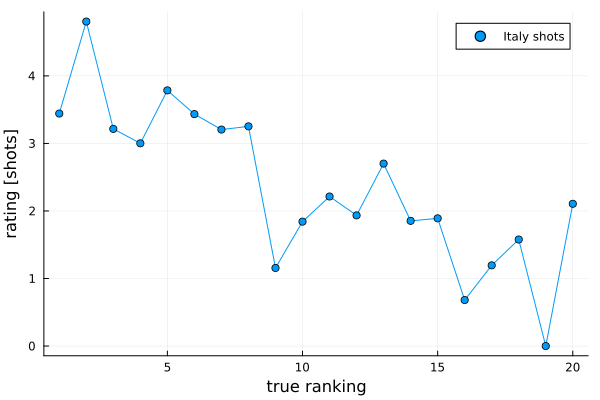

In [53]:
p = plot(
    xlabel="true ranking",
    ylabel="rating ["*metric*"]",
)
plot!(w,c=1,label="")
scatter!(w,c=1,label=league*" "*metric)
fname = "plots/tmp/"*league*"-"*metric*"-rating.pdf"
#@show fname
savefig(p,fname)
display(p)

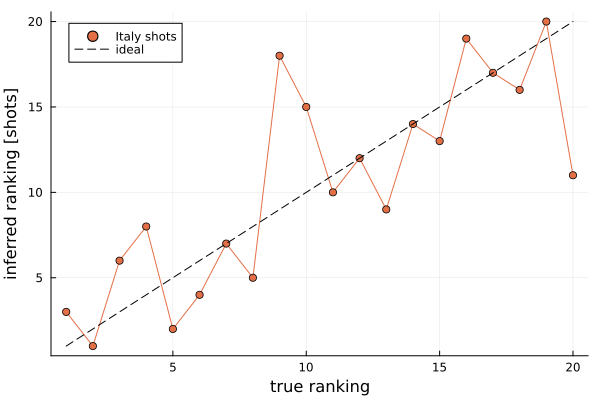

In [54]:
p = plot(
    xlabel="true ranking",
    ylabel="inferred ranking ["*metric*"]",
)
plot!(r,c=2,label="")
scatter!(r,c=2,label=league*" "*metric)
plot!(x->x,c=:black,style=:dash,label="ideal")
fname = "plots/tmp/"*league*"-"*metric*"-ranking.pdf"
#@show fname
savefig(p,fname)
display(p)

### Systematic computation of ratings and rankings

In [55]:
function save_ratings_and_rankings_as_txt(fname,w,r)
    fhw = open(fname,"w")
    println(fhw,"i w_i r_i")
    for i in 1:length(w)
        println(fhw,i," ",w[i]," ",r[i])
    end
    close(fhw)
end

save_ratings_and_rankings_as_txt (generic function with 1 method)

In [57]:
for (k,g) in dict_weighted_g_jld2
    #@show k,g
    (league,metric) = k
    @show league,metric
    sc,f = g_to_sc_f(g)
    hd = compute_k_th_hodge_decomposition(sc,f,1)
    w = ratings(hd.w)
    r = ranking(hd.w)
    #@show k,w,r
    # Plot inferred rating
    p = plot(
        xlabel="true ranking",
        ylabel="rating ["*metric*"]",
    )
    plot!(w,c=1,label="")
    scatter!(w,c=1,label=league*" "*metric)
    fname = "plots/"*league*"-"*metric*"-rating.pdf"
    #@show fname
    savefig(p,fname)
    fname = "txt/"*league*"-"*metric*"-rating.txt"    
    #display(p)
    # Plot inferred ranking
    p = plot(
        xlabel="true ranking",
        ylabel="inferred ranking ["*metric*"]",
    )
    plot!(r,c=2,label="")
    scatter!(r,c=2,label=league*" "*metric)
    plot!(x->x,c=:black,style=:dash,label="ideal")
    fname = "plots/"*league*"-"*metric*"-ranking.pdf"
    #@show fname
    savefig(p,fname)
    #display(p)
    # Save ratings and rankings as txt
    fname = "txt/"*league*"-"*metric*".txt"    
    save_ratings_and_rankings_as_txt(fname,w,r)        
end

(league, metric) = ("Italy", "crossing")
(league, metric) = ("Spain", "pressure_loss")
(league, metric) = ("Spain", "direct_play")
(league, metric) = ("England", "T_zona_media")
(league, metric) = ("England", "T_build_up")
(league, metric) = ("Italy", "pressure_loss")
(league, metric) = ("Spain", "T_build_up")
(league, metric) = ("Italy", "shots")
(league, metric) = ("Germany", "counterattack")
(league, metric) = ("England", "flow_rate")
(league, metric) = ("Germany", "T_maintenance")
(league, metric) = ("Italy", "direct_play")
(league, metric) = ("England", "shots")
(league, metric) = ("Spain", "flow_rate")
(league, metric) = ("Spain", "counterattack")
(league, metric) = ("Germany", "direct_play")
(league, metric) = ("England", "pressure_loss")
(league, metric) = ("France", "T_zona_media")
(league, metric) = ("France", "T_build_up")
(league, metric) = ("England", "counterattack")
(league, metric) = ("Germany", "flow_rate")
(league, metric) = ("Germany", "T_build_up")
(league, metric) 